<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-stft-visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/philippmatthes/diplom

Cloning into 'diplom'...
remote: Enumerating objects: 1801, done.
remote: Counting objects: 100% (1138/1138), done.
remote: Compressing objects: 100% (773/773), done.
remote: Total 1801 (delta 573), reused 832 (delta 307), pack-reused 663
Receiving objects: 100% (1801/1801), 34.70 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (949/949), done.


In [ ]:
%cd /content/diplom/src
!mkdir shl-dataset

/content/diplom/src


In [ ]:
!wget -nc -O shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip

In [ ]:
!unzip -n -d shl-dataset/challenge-2020-users23_torso_bag_hips_hand shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip
!rm shl-dataset/challenge-2020-users23_torso_bag_hips_hand.zip

In [ ]:
%cd /content/diplom/src
%tensorflow_version 2.x

/content/diplom/src


In [ ]:
# Check configuration and hardware resources

import distutils

import tensorflow as tf

if distutils.version.LooseVersion(tf.__version__) < '2.0':
    raise Exception('This notebook is compatible with TensorFlow 2.0 or higher.')

In [ ]:
from pathlib import Path

TRAIN_DATASET_DIRS = [
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso'),         
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag'),   
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips'),   
    Path('shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand'),   
]

In [ ]:
LABEL_ORDER = [
    'Null',
    'Still',
    'Walking',
    'Run',
    'Bike',
    'Car',
    'Bus',
    'Train',
    'Subway',
]

SAMPLE_LENGTH = 500

In [ ]:
CLASS_WEIGHTS = {
    0: 0.0, # NULL label
    1: 1.0021671573438011, 
    2: 0.9985739895697523, 
    3: 2.8994439843842423, 
    4: 1.044135815617944, 
    5: 0.7723505499007343, 
    6: 0.8652474758172704, 
    7: 0.7842127155793044, 
    8: 1.0283208861290594
}

In [ ]:
from collections import OrderedDict

import numpy as np

# Attributes to load from our dataset
X_attributes = [
    'acc_x', 'acc_y', 'acc_z',
    'mag_x', 'mag_y', 'mag_z',
    'gyr_x', 'gyr_y', 'gyr_z',
    # Parts that are not needed:
    # 'gra_x', 'gra_y', 'gra_z',
    # 'lacc_x', 'lacc_y', 'lacc_z',
    # 'ori_x', 'ori_y', 'ori_z', 'ori_w',
]

# Files within the dataset that contain our attributes
X_files = [
    'Acc_x.txt', 'Acc_y.txt', 'Acc_z.txt',
    'Mag_x.txt', 'Mag_y.txt', 'Mag_z.txt',
    'Gyr_x.txt', 'Gyr_y.txt', 'Gyr_z.txt',
    # Parts that are not needed:
    # 'Gra_x.txt', 'Gra_y.txt', 'Gra_z.txt',
    # 'LAcc_x.txt', 'LAcc_y.txt', 'LAcc_z.txt',
    # 'Ori_x.txt', 'Ori_y.txt', 'Ori_z.txt', 'Ori_w.txt',
]

# Features to generate from our loaded attributes
# Note that `a` is going to be a dict of attribute tracks
X_features = OrderedDict({
    'acc_mag': lambda a: np.sqrt(a['acc_x']**2 + a['acc_y']**2 + a['acc_z']**2),
    'mag_mag': lambda a: np.sqrt(a['mag_x']**2 + a['mag_y']**2 + a['mag_z']**2),
    'gyr_mag': lambda a: np.sqrt(a['gyr_x']**2 + a['gyr_y']**2 + a['gyr_z']**2),
})

# Define where to find our labels for supervised learning
y_file = 'Label.txt'
y_attribute = 'labels'

In [ ]:
import joblib

X_feature_scalers = OrderedDict({})
for feature_name, _ in X_features.items():
    scaler_dir = f'models/shl-scalers/{feature_name}.scaler.joblib'
    scaler = joblib.load(scaler_dir)
    scaler.copy = False # Save memory
    X_feature_scalers[feature_name] = scaler
    print(f'Loaded scaler from {scaler_dir}.')

Loaded scaler from models/shl-scalers/acc_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/mag_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/gyr_mag.scaler.joblib.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PowerTransformer from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
import os
import shutil

from typing import Generator, List, Tuple

from tqdm import tqdm

import pandas as pd

def read_chunks(
    n_chunks: int, 
    X_attr_readers: List[pd.io.parsers.TextFileReader], 
    y_attr_reader: pd.io.parsers.TextFileReader
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Read chunks of attribute data and yield it to the caller as tuples of X, y.
    
    This function returns a generator which can be iterated.
    """
    for _ in range(n_chunks):
        # Load raw attribute tracks
        X_raw_attrs = OrderedDict({})
        for X_attribute, X_attr_reader in zip(X_attributes, X_attr_readers):
            X_attr_track = next(X_attr_reader)
            X_attr_track = np.nan_to_num(X_attr_track.to_numpy())
            X_raw_attrs[X_attribute] = X_attr_track

        # Calculate features
        X_feature_tracks = None
        for X_feature_name, X_feature_func in X_features.items():
            X_feature_track = X_feature_func(X_raw_attrs)
            X_feature_track = X_feature_scalers[X_feature_name] \
                .transform(X_feature_track)
            if X_feature_tracks is None:
                X_feature_tracks = X_feature_track
            else:
                X_feature_tracks = np.dstack((X_feature_tracks, X_feature_track))

        # Load labels
        y_attr_track = next(y_attr_reader) # dim (None, sample_length)
        y_attr_track = np.nan_to_num(y_attr_track.to_numpy()) # dim (None, sample_length)
        y_attr_track = y_attr_track[:, 0] # dim (None, 1)

        yield X_feature_tracks, y_attr_track

def count_samples(dataset_dir: Path) -> int:
    """Count the total amount of samples in a shl dataset."""
    n_samples = 0
    # Every file in the dataset has the same length, use the labels file
    with open(dataset_dir / y_file) as f:
        for _ in tqdm(f, desc=f'Counting samples in {dataset_dir}'):
            n_samples += 1
    return n_samples

def create_chunked_readers(
    dataset_dir: Path,
    chunksize: int, 
    xdtype=np.float32, # Use np.float16 with caution, can lead to overflows
    ydtype=np.int
) -> Tuple[List[pd.io.parsers.TextFileReader], pd.io.parsers.TextFileReader]:
    """Initialize chunked csv readers and return them to the caller as a tuple."""
    read_csv_kwargs = { 'sep': ' ', 'header': None, 'chunksize': chunksize }

    X_attr_readers = [] # (dim datasets x readers)
    for filename in X_files:
        X_reader = pd.read_csv(dataset_dir / filename, dtype=xdtype, **read_csv_kwargs)
        X_attr_readers.append(X_reader)
    y_attr_reader = pd.read_csv(dataset_dir / y_file, dtype=ydtype, **read_csv_kwargs)

    return X_attr_readers, y_attr_reader

def export_tfrecords(
    dataset_dir: Path,
    n_chunks=16, # Load dataset in parts to not overload memory
):
    """Transform the given shl dataset into a memory efficient TFRecord."""
    target_dir = f'{dataset_dir}.tfrecord'
    if os.path.isfile(target_dir):
        print(f'{target_dir} already exists.')
        return

    print(f'Exporting to {target_dir}.')

    n_samples = count_samples(dataset_dir)
    chunksize = int(np.floor(n_samples / n_chunks))
    X_attr_readers, y_attr_reader = create_chunked_readers(dataset_dir, chunksize)    

    with tf.io.TFRecordWriter(str(target_dir)) as file_writer:
        with tqdm(total=n_samples, desc=f'Reading samples to {target_dir}') as pbar:
            for X_feature_tracks, y_attr_track in read_chunks(
                n_chunks, X_attr_readers, y_attr_reader
            ):
                for X, y in zip(X_feature_tracks, y_attr_track):
                    X_flat = X.flatten() # TFRecords don't support multidimensional arrays
                    record_bytes = tf.train.Example(features=tf.train.Features(feature={
                        'X': tf.train.Feature(float_list=tf.train.FloatList(value=X_flat)),
                        'y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])) 
                    })).SerializeToString()
                    file_writer.write(record_bytes)
                pbar.update(chunksize)

for dataset_dir in TRAIN_DATASET_DIRS:
    export_tfrecords(dataset_dir)

Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso: 28789it [00:00, 823432.70it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord: 100%|█████████▉| 28784/28789 [00:44<00:00, 650.50it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag: 28789it [00:00, 129083.31it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord: 100%|█████████▉| 28784/28789 [00:47<00:00, 603.54it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips: 28789it [00:00, 124921.19it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord: 100%|█████████▉| 28784/28789 [00:47<00:00, 609.60it/s]


Exporting to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord.


Counting samples in shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand: 28789it [00:00, 129215.50it/s]
Reading samples to shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord: 100%|█████████▉| 28784/28789 [00:48<00:00, 595.99it/s]


In [ ]:
def decode_tfrecord(record_bytes) -> Tuple[tf.Tensor, tf.Tensor]:
    """Decode a TFRecord example to X, y from its serialized representation."""
    example = tf.io.parse_single_example(record_bytes, {
        'X': tf.io.FixedLenFeature([SAMPLE_LENGTH, len(X_features)], tf.float32),
        'y': tf.io.FixedLenFeature([1], tf.int64)
    })
    return example['X'], example['y']

def create_train_validation_datasets(
    dataset_dirs: List[Path], 
    batch_size=64,
    shuffle_size=20_000, # Must be larger than batch_size
    test_size=256 # In batches
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Create interleaved, shuffled and batched train and 
    validation datasets from the dataset dirs.
    
    Note that this function reads previously generated TFRecords under 
    `dataset_dir.tfrecord` -> use `export_tfrecords` for that.
    """
    tfrecord_dirs = [f'{d}.tfrecord' for d in dataset_dirs]
    print(f'Creating train and validation dataset over {tfrecord_dirs}.')

    # Create a strategy to interleave the datasets
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_dirs) \
        .interleave(
            lambda x: tf.data.TFRecordDataset(x), 
            cycle_length=batch_size, # Number of input elements that are processed concurrently
            block_length=1 # Return only one element at a time, batching is done later
        ) \
        .shuffle(shuffle_size) \
        .map(decode_tfrecord, num_parallel_calls=tf.data.AUTOTUNE) \
        .batch(batch_size)
    count = sum(1 for _ in dataset)
    print(f'Counted {count * batch_size} samples in combined dataset.')
    training_dataset = dataset.skip(test_size)
    count = sum(1 for _ in training_dataset)
    print(f'Counted {count * batch_size} samples in training dataset.')
    validation_dataset = dataset.take(test_size)
    count = sum(1 for _ in validation_dataset)
    print(f'Counted {count * batch_size} samples in validation dataset.')
    return training_dataset, validation_dataset

train_dataset, validation_dataset = create_train_validation_datasets(TRAIN_DATASET_DIRS)

Creating train and validation dataset over ['shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Torso.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Bag.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hips.tfrecord', 'shl-dataset/challenge-2020-users23_torso_bag_hips_hand/validation/Hand.tfrecord'].
Counted 115136 samples in combined dataset.
Counted 98752 samples in training dataset.
Counted 16384 samples in validation dataset.


In [ ]:
# We will use the kapre contribution package to include STFT layers

!{sys.executable} -m pip install kapre -q

/bin/bash: {sys.executable}: command not found


In [ ]:
import kapre

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

input_shape = (SAMPLE_LENGTH, len(X_features))

model = models.Sequential([
    # Short-time fourier transform
    kapre.STFT(
        n_fft=100,
        hop_length=5,
        pad_end=False,
        input_data_format='channels_last', 
        output_data_format='channels_last',
        input_shape=input_shape,
        name='stft-layer'
    ),
    kapre.Magnitude(),
    kapre.MagnitudeToDecibel(),

    layers.UpSampling2D(2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(LABEL_ORDER), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy', # No OHE necessary
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft-layer (STFT)            (None, 81, 51, 3)         0         
_________________________________________________________________
magnitude (Magnitude)        (None, 81, 51, 3)         0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 81, 51, 3)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 162, 102, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 100, 32)      896       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 2

In [ ]:
model.fit(train_dataset, validation_data=validation_dataset, epochs=1, verbose=1, shuffle=False, class_weight=CLASS_WEIGHTS)

In [ ]:
vis_model = models.Model(inputs=model.input, outputs=model.layers[3].output)

<Figure size 432x288 with 0 Axes>

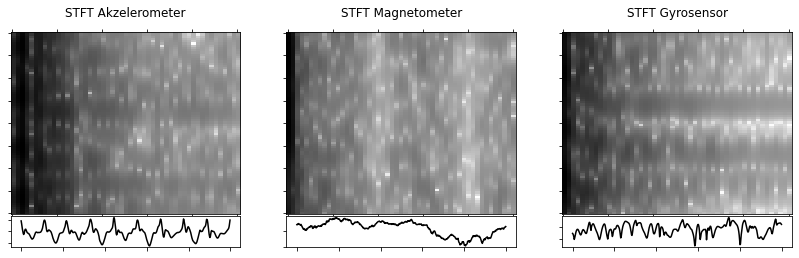

In [ ]:
from matplotlib import pyplot as plt

sample = next(iter(validation_dataset))[0]

result = vis_model.predict(sample)[0]

plt.clf()
fig, axs = plt.subplots(2, 3, gridspec_kw={'height_ratios': [6, 1], 'hspace': 0.0})
fig.set_size_inches(14, 4)

axs[0, 0].matshow(result[::2, :, 0], cmap=plt.cm.binary)
axs[1, 0].plot(sample[0, :, 0], color='black')
axs[0, 0].set_title('STFT Akzelerometer')
axs[0, 1].matshow(result[::2, :, 1], cmap=plt.cm.binary)
axs[1, 1].plot(sample[0, :, 1], color='black')
axs[0, 1].set_title('STFT Magnetometer')
axs[0, 2].matshow(result[::2, :, 2], cmap=plt.cm.binary)
axs[1, 2].plot(sample[0, :, 2], color='black')
axs[0, 2].set_title('STFT Gyrosensor')

for row in axs:
    for ax in row:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

plt.savefig(
    f'../images/shl/stft-layer-output.pdf',
    dpi=1200,
    bbox_inches='tight'
)
plt.show()